In [1]:
import torch
import numpy as np

from IPython import display
from torch import nn
from matplotlib import pyplot as plt

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
class RealDataDataset(torch.nn.Module):
    def create_dataset(self, start=1, end=200, amount=5000):
        x = torch.linspace(start=start, end=end, steps=amount, dtype=torch.float32)
        return x, torch.sin(x) / x - x / 10

    def __init__(self, start=1, end=200, amount=5000):
        self.data = self.create_dataset(start, end, amount)
    
    def __getitem__(self, indx):
        return self.data[0][indx], self.data[1][indx]
    
    def __len__(self):
        return self.data[0].shape[0]

In [10]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.4, inplace=True)],
            ['relu', nn.ReLU()],
            ['sigmoid', nn.Sigmoid()],
            ['htang', nn.Tanh()]
            
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            lin = nn.Linear(in_feat, out_feat)
            torch.nn.init.kaiming_normal_(lin.weight)
            
            layers = [lin]  # Если мы создаем последовательность слоев - то мы задаем их
                                                     # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  # Эта строчка означает тоже самое что и
                                                         # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),  # Звездочка означает unpacking списка  
            *block(128, 256, activation='lrelu'),
            *block(256, 512, activation='lrelu'),
            *block(512, 1024, activation='lrelu'),
            *block(1024, 512, activation='lrelu'),
            *block(512, 256, activation='lrelu'),
            *block(256, 128, activation='lrelu'),
            *block(128, 64, activation='lrelu'),
            *block(64, 32, activation='lrelu'),
            *block(32, 2, activation='lrelu', normalize=False),

        )

    def forward(self, x):
        return self.model(x)

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, x):
#         x = x.view(-1, 1)
        return self.model(x)

In [12]:
def plot_batch(true_batch, gen_batch):
    (true_x, true_y), (gen_x, gen_y) = true_batch, gen_batch
    true_x, true_y, gen_x, gen_y = true_x.cpu().detach(), true_y.cpu().detach(), gen_x.cpu().detach(), gen_y.cpu().detach()
    
    plt.figure(figsize=(16, 9))
    plt.plot(true_x, true_y,'-o', c='blue')
    plt.plot(gen_x, gen_y,'o', c='green')
    plt.show()

<Figure size 432x288 with 0 Axes>

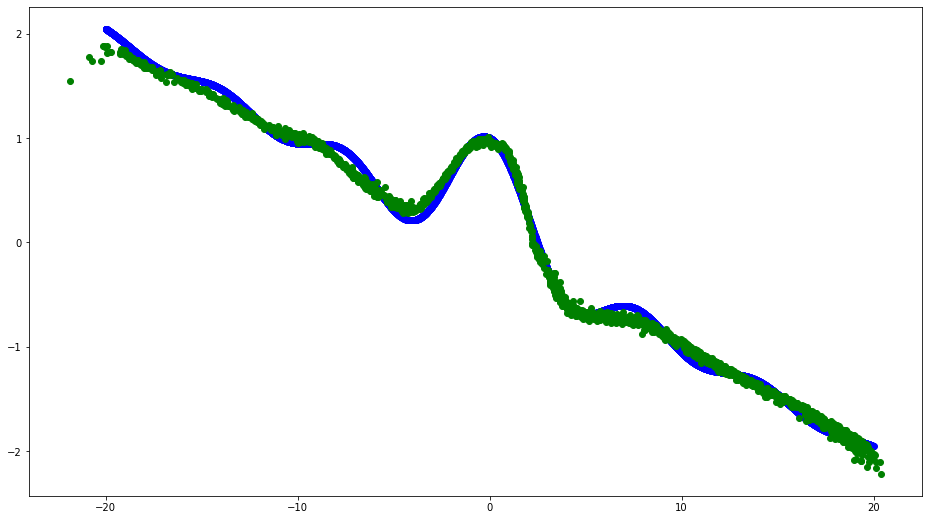

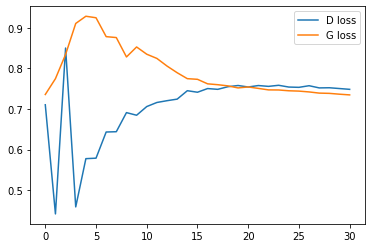

[Epoch 155/300] [Batch 2/3]|[D loss: 0.7482693195343018] [G loss: 0.7337746024131775]
[Epoch 160/300] [Batch 2/3]|[D loss: 0.7458727955818176] [G loss: 0.7312427759170532]
[Epoch 165/300] [Batch 2/3]|[D loss: 0.743578314781189] [G loss: 0.7305158972740173]
[Epoch 170/300] [Batch 2/3]|[D loss: 0.7419836521148682] [G loss: 0.7287006378173828]
[Epoch 175/300] [Batch 2/3]|[D loss: 0.7402437925338745] [G loss: 0.7268444299697876]
[Epoch 180/300] [Batch 2/3]|[D loss: 0.737933874130249] [G loss: 0.7262113094329834]
[Epoch 185/300] [Batch 2/3]|[D loss: 0.7362375855445862] [G loss: 0.7244346737861633]
[Epoch 190/300] [Batch 2/3]|[D loss: 0.7344049215316772] [G loss: 0.7224727869033813]
[Epoch 195/300] [Batch 2/3]|[D loss: 0.7324451208114624] [G loss: 0.7212103009223938]
[Epoch 200/300] [Batch 2/3]|[D loss: 0.7306379079818726] [G loss: 0.719733476638794]
[Epoch 205/300] [Batch 2/3]|[D loss: 0.72847580909729] [G loss: 0.7186258435249329]
[Epoch 210/300] [Batch 2/3]|[D loss: 0.7266186475753784] [G

In [13]:
import matplotlib.patches as mpatches

n_epochs = 300  # количество эпох
lr = 0.002 # шаг обучения
batch_size = 2000
latent_dim = 100  # Размерность случайного вектора, который подается на вход генератору
b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

real_dataset = RealDataDataset(start=-20, end=20, amount=6000)
real_data = torch.utils.data.DataLoader(dataset=real_dataset, batch_size=batch_size)

generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)
generator.train()
discriminator.train()

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr,
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr,
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

d_loss_history = []
g_loss_history = []


def get_noize(since=-20, to=20):
    return torch.FloatTensor(np.random.uniform(-20, 20, (batch_size, latent_dim)))

for epoch in range(n_epochs):
    for i, (x, y) in enumerate(real_data):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)
        
        real_xy = torch.stack([x, y], dim=1).to(device)
        
        # Генерация шума
        z = get_noize().to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_x = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_xy)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_x)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        z = get_noize().to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_x = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_x)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
        
    if not epoch % 5:
        with torch.no_grad():
            print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(real_data)}]", end='|')
            print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 
            d_loss = d_loss.cpu().detach()
            g_loss = g_loss.cpu().detach()


            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

######## Отображение процесса обучения и вывод функций потерь ############
    if not epoch % 150:
        with torch.no_grad():
            plt.clf()
            display.clear_output(wait=False)
            
            gen_data = generator(get_noize().to(device))
      
            plot_batch((real_dataset.data[0], real_dataset.data[1]), (gen_data[:,0], gen_data[:,1]))

            plt.plot(np.array(d_loss_history), label='D loss')
            plt.plot(np.array(g_loss_history), label='G loss')
            plt.legend()
            plt.show()  